# Определение вероятности покупки в Интернет-магазине

## Описание проекта

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

**Цель:** Предсказать вероятность покупки в течение 90 дней

Задачи:
- Изучить данные
- Разработать полезные признаки
- Создать модель для классификации пользователей
- Улучшить модель и максимизировать метрику `roc_auc` (минимальное пороговое значение `0.7`)
- Выполнить тестирование

## Описание данных

`apparel-purchases`

Данные о покупках клиентов по дням и по товарам. В каждой записи покупка
определенного товара, его цена, количество штук.

В таблице есть списки идентификаторов, к каким категориям относится товар. Часто это вложенные категории (например автотовары-аксессуары-освежители), но также может включать в начале списка маркер распродажи или маркер женщинам/мужчинам.

Нумерация категорий сквозная для всех уровней, то есть 44 на второй позиции списка или на третьей – это одна и та же категория. Иногда дерево категорий обновляется, поэтому могут меняться вложенности, например ['4', '28', '44', '1594'] или ['4', '44', '1594'].

- `client_id` - идентификатор клиента
- `quantity` - количество единиц товара
- `price` - цена товара
- `category_ids` - идентификаторы категорий
- `date` - дата покупки
- `message_id` - идентификатор сообщения из рассылки

`apparel-messages`

Рассылки, которые были отправлены клиентам из таблицы покупок.

- `bulk_campaign_id` - идентификатор рассылки
- `client_id` - идентификатор клиента
- `message_id` - идентификатор сообщения
- `event` - действие с сообщением (отправлено, открыто, покупка…)
- `channel` - канал рассылки
- `date` - дата действия
- `created_at` - дата-время полностью

`apparel-target_binary`

- `client_id` - идентификатор клиента
- `target` - клиент совершил покупку в целевом периоде

## Подготовительный этап

### Загрузка данных с GD

In [1]:
# Загрузка файлов данных с GD
! gdown --id 187qexCOqKzWdwgI0mcRDHMPR16okBALG -q
! gdown --id 1YbJD2B9odDldSs2Ck1j9_-QQ7RTLp12c -q
! gdown --id 1O7yJDc9U-veD3HJC0Ob597OauPugKylV -q

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(


### Библиотеки

In [111]:
#Устанавливаем нужные библиотеки
! pip install phik -q
! pip install catboost -q
! pip install shap -q

In [112]:
# импортируем библиотеки, которые могут понадобиться нам при исследовании
from datetime import timedelta
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import warnings
from scipy import stats as st

from sklearn.model_selection import (train_test_split, RandomizedSearchCV,
                                     GridSearchCV)

from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             roc_auc_score, f1_score)

from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, LabelEncoder,
                                   StandardScaler, MultiLabelBinarizer)
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import phik
import shap

# Убираем ограничение на вывод столбцов
pd.set_option('display.max_columns', None)

In [113]:
# Создаем файл requirements.txt
! pip freeze > requirements.txt

### Константы

In [5]:
# Зададим константы с путём к данным

PURCHASE_DATA = '/content/apparel-purchases.csv'
MARKETING_DATA = '/content/apparel-messages.csv'
TARGET_DATA = '/content/apparel-target_binary.csv'

# задаём константы
RANDOM_STATE = 42

TEST_SIZE = 0.20

### Функции

#### Загрузка/сохранение данных

In [6]:
def read_and_show_info(path, sep=',', decimal='.', parse_dates=[]):
    """
    Функция для прочтения и вывода информации о датасете
    """
    data = pd.read_csv(path, sep=sep, decimal=decimal, parse_dates=parse_dates)

    # Выводим информацию о данных в датафрейме
    display(data.info())
    display(data.head().T)

    return data

In [7]:
# Оптимизация числовых типов данных
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    '''
    Function optimizes memory usage in dataframe
    df: pd.DataFrame - data table
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))

    return df

#### Анализ данных

In [8]:
def check_cat_features(data):
    """
    Функция для проверки категориальных признаков
    """
    col_set = data.select_dtypes(include='object').columns.to_list()
    for col in col_set:
        print(f'Значения столбца {col} ({data[col].nunique()})')

    return None

In [9]:
def cat_features_analysis_df(data, col, title):
    """
    Функция для анализа категориального признака
    """
    # Построим частоту по информации о признаке
    tmp_ser = data[col].value_counts()
    # Преобразуем в df
    tmp_df = tmp_ser.to_frame()
    tmp_df.columns = ['Количество']
    # Добавим процент в столбце
    tmp_df['%'] = round(tmp_df['Количество'] /
                        tmp_df['Количество'].sum() * 100,
                        2
                       )
    display(tmp_df)

    # строим круговую диаграмму по категориальному признаку
    colors = ['#FABD64','#7DB4FC', '#04FE95', '#FB8095']

    data[col].value_counts().plot.pie(figsize=(6, 6),
                                      autopct='%1.1f%%',
                                      wedgeprops={'linewidth': 1.0, 'edgecolor': 'white'},
                                      textprops={'size': 'large'},
                                      colors=colors
                                     )

    plt.title(title, fontsize=18)
    plt.ylabel('')

    plt.show()

    return None

In [10]:
def num_features_analysis(data, col, title, x_label, bins=30):
    """
    Функция для анализа количественных показателей
    """
    # Выведем описательные статистики
    display(data[col].describe());

    fig = plt.figure(figsize=(18, 8))
    gs = GridSpec(1, 2, width_ratios=[1, 2])  # Настройка ширины подграфиков

    plt.title(title)

    # Посроим Боксплот диаграмму
    ax1 = fig.add_subplot(gs[0])
    sns.boxplot(ax=ax1, data=data, y=col);

    ax1.set_ylabel(x_label)
    ax1.grid(axis='y')  # Отображение сетки только по горизонтали

    # Построим гистограмму с разделением по целевому признаку
    ax2 = fig.add_subplot(gs[1])
    sns.histplot(ax=ax2, data=data, x=col, bins=bins);

    ax2.set_xlabel(x_label)
    ax2.set_ylabel('Количество')

    plt.tight_layout()
    plt.show()

    return None

In [54]:
def date_analysis(data, col, title, y_label, bins=30):
  # Построение гистограммы распределения дат
  plt.figure(figsize=(12, 6))
  sns.histplot(data[col], bins=bins, kde=True,
               color='blue', edgecolor='black')

  # Настройки графика
  plt.title(title, fontsize=16)
  plt.xlabel('Дата', fontsize=14)
  plt.ylabel(y_label, fontsize=14)
  plt.xticks(rotation=45)
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.tight_layout()

  # Показ графика
  plt.show()

  return None

#### Моделирование

In [11]:
def split_data(data, cat_col, num_col):
    """
    Разделение выборки на тренировочную и валидационную.
    Возвращает X_train, X_test, y_train, y_test
    """
    X_train, X_test, y_train, y_test = train_test_split(
        data[cat_col+num_col],
        data[target_col],
        test_size = TEST_SIZE,
        random_state = RANDOM_STATE,
        stratify = data[target_col]
    )

    return X_train, X_test, y_train, y_test

In [12]:
# Создадим функцию поиска лучшей модели
def param_search(X_train, y_train, type='grid', scoring='roc-auc'):
    '''
    Функция для поиска лучшей модели

     param_grid - словарь с параметрами
     type - тип поиска
    '''
    if type == 'random':
        grid = RandomizedSearchCV(
            pipe_final,
            param_distributions=param_grid,
            cv=5,
            scoring=scoring,
            n_jobs=-1,
            n_iter=100,
            random_state=RANDOM_STATE
        )
    else:
        grid = GridSearchCV(
            pipe_final,
            param_grid=param_grid,
            cv=5,
            scoring=scoring,
            n_jobs=-1
        )

    grid.fit(X_train, y_train)

    print(f'Метрика "{scoring}" для лучшей модели: ', round(grid.best_score_, 5), '\n')
    print('Лучшая модель:\n\n', grid.best_estimator_)
    print('Параметры модели:\n\n', grid.best_params_)

    return grid

In [13]:
# Выводим метрики
def model_predict(model):
    '''
    Функция для вывода метрик

     model - обученная модель
    '''
    y_test_pred_proba = model.predict_proba(X_test)
    y_test_pred = model.predict(X_test)
    print(f'Метрика ROC_AUC на тестовой выборке: {round(roc_auc_score(y_test, y_test_pred_proba[:,1]), 3)}')
    print(f'Метрика F1 на тестовой выборке: {round(f1_score(y_test, y_test_pred), 3)}')

In [14]:
def conf_matrix(model):
    '''
    Функция для вывода матрицы ошибок

     model - обученная модель
    '''
    y_test_pred = model.predict(X_test)
    # Строим матрицу ошибок
    cm = confusion_matrix(y_test, y_test_pred)

    # Отображение матрицы ошибок
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='viridis')
    plt.show()

    return cm

## Знакомство с данными

### Загрузка данных о покупках

In [15]:
# Знакомимся с данными о покупках
purchase_data = read_and_show_info(PURCHASE_DATA, parse_dates=['date'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


None

,0,1,2,3,4
client_id,1515915625468169594,1515915625468169594,1515915625471138230,1515915625471138230,1515915625471138230
quantity,1,1,1,1,1
price,1999.0,2499.0,6499.0,4999.0,4999.0
category_ids,"['4', '28', '57', '431']","['4', '28', '57', '431']","['4', '28', '57', '431']","['4', '28', '244', '432']","['4', '28', '49', '413']"
date,2022-05-16 00:00:00,2022-05-16 00:00:00,2022-05-16 00:00:00,2022-05-16 00:00:00,2022-05-16 00:00:00
message_id,1515915625468169594-4301-627b661e9736d,1515915625468169594-4301-627b661e9736d,1515915625471138230-4437-6282242f27843,1515915625471138230-4437-6282242f27843,1515915625471138230-4437-6282242f27843


In [16]:
purchase_data = optimize_memory_usage(purchase_data)

Размер использования памяти: до  9.26 Mb - после  7.14 Mb (22.9%)


In [17]:
uniq_byers = purchase_data['client_id'].nunique()
uniq_byers

49849

- В нашем распоряжении данные о покупках почти 50 000 клиентов
- Пропусков в данных нет
- именования столбцов согласно стандарту

In [18]:
check_cat_features(purchase_data)

Значения столбца category_ids (933)
Значения столбца message_id (50204)


- Почти 1000 значений в признаке Категорий покупок
- 50 000 идентификаторов сообщений

С Категориями нужно что-то придумать для их использования в модели.

In [19]:
# Проверим на наличие дубликатов
purchase_data.duplicated().sum()

73020

Очень много дублирующихся записей, но не будем удалять их, т.к.
- в дате покупки нет времени и это могут быть валидные покупки от одного пользователя в течении одного дня
- таким образом может хранить данные магазин, просто записывая каждую единицу товара отдельно в БД

### Загрузка данных о таргете

In [20]:
# Знакомимся с данными о таргете
target_data = read_and_show_info(TARGET_DATA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


None

,0,1,2,3,4
client_id,1515915625468060902,1515915625468061003,1515915625468061099,1515915625468061100,1515915625468061170
target,0,1,0,0,0


In [21]:
target_data['client_id'].nunique()

49849

- Количество данных о Таргете по клиентам совпадает с количеством уникальных клиентов в таблице покупок
- Пропусков в данных нет
- именования столбцов согласно стандарту

,Количество,%
target,,
0,48888,98.07
1,961,1.93


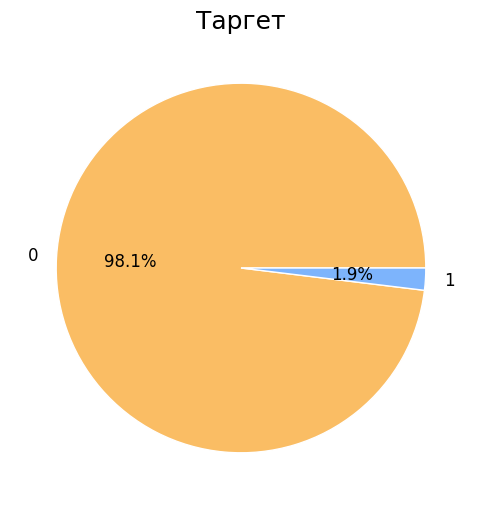

In [22]:
cat_features_analysis_df(target_data, 'target', 'Таргет')

Таргет распределен очень неравномерно. Вероятность повторной покупки на сайте не превышает 2%.

### Загрузка данных о рассылках

In [23]:
# Знакомимся с данными о рассылках
msgs_data = read_and_show_info(MARKETING_DATA, parse_dates=['date', 'created_at'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


None

,0,1,2,3,4
bulk_campaign_id,4439,4439,4439,4439,4439
client_id,1515915625626736623,1515915625490086521,1515915625553578558,1515915625553578558,1515915625471518311
message_id,1515915625626736623-4439-6283415ac07ea,1515915625490086521-4439-62834150016dd,1515915625553578558-4439-6283415b36b4f,1515915625553578558-4439-6283415b36b4f,1515915625471518311-4439-628341570c133
event,open,open,open,click,open
channel,email,email,email,email,email
date,2022-05-19 00:00:00,2022-05-19 00:00:00,2022-05-19 00:00:00,2022-05-19 00:00:00,2022-05-19 00:00:00
created_at,2022-05-19 00:14:20,2022-05-19 00:39:34,2022-05-19 00:51:49,2022-05-19 00:52:20,2022-05-19 00:56:52


Можно заметить, что структура текстового идентификатора сообщения (`message_id`) реально содержит 3 части:
- Идентификатор пользователя
- Идентификатор маркетинговой компании
- Уникальный идентификатор сообщения

In [24]:
msgs_data = optimize_memory_usage(msgs_data)

Размер использования памяти: до 680.38 Mb - после 607.48 Mb (10.7%)


In [25]:
uniq_market_targets = msgs_data['client_id'].nunique()
uniq_market_targets

53329

In [26]:
print(f'{uniq_byers/uniq_market_targets * 100}%')

93.4744698006713%


- В нашем распоряжении данные о маркетиноговой активности с  53 000 клиентов.
- Уникальных клиентов в этой таблице больше, чем в таблице с покупками. Только 93% клиентов, получающих рассылки хоть раз совершали покупки на сайте.
- Пропусков в данных нет
- именования столбцов согласно стандарту

In [27]:
check_cat_features(msgs_data)

Значения столбца message_id (9061667)
Значения столбца event (11)
Значения столбца channel (2)


- 11 значений в признаке Событие
- 2 канала рассылок
- 9 миллионов разных сообщений (!)

In [28]:
msgs_data['channel'].unique()

array(['email', 'mobile_push'], dtype=object)

Рассылки идут по каналу Email и через Push-уведомления

In [29]:
msgs_data['event'].unique()

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
      dtype=object)

- Признак отправки сообщения - `send` (отправлено)
- Позитивные реакции на сообщения - `open` (открыто), `click` (переход), `purchase` (покупка), `subscribe` (подписка)
- Негативные реакции на сообщения - `unsubscribe` (отписка), `complain` (жалоба), `close` (закрыто)
- Сообщения, которые не достигли адресата - `hbq_spam` (попало в спам), `hard_bounce` (аппаратная ошибка), `soft_bounce` (программная ошибка) - *их можно исключить из анализа*

In [30]:
# Проверим на наличие дубликатов
msgs_data.duplicated().sum()

48610

Поскольку в этой таблице есть четкая временная метка у каждой записи, то дубликаты можно удалить.

In [31]:
# Удалим дубликаты
msgs_data = msgs_data.drop_duplicates()

Удалим целиком информацию о сообщениях, содержащих статусы недоставки адресату

In [32]:
# Нежелательные статусы
exclude_events = ['hbq_spam', 'hard_bounce', 'soft_bounce']

# Определяем message_id, которые содержат нежелательные статусы
excluded_message_ids = msgs_data[msgs_data['event'].isin(exclude_events)]['message_id'].unique()

# Удаляем все строки с этими message_id
msgs_data = msgs_data[~msgs_data['message_id'].isin(excluded_message_ids)]

### Выводы по знакомству с данными

**Данные о покупках**
- В нашем распоряжении данные о покупках почти 50 000 клиентов
- Очень много дублирующихся записей в информации о покупках (почти 70 000), но мы не стали их удалять, т.к.
  - в дате покупки нет времени и это могут быть валидные покупки от одного пользователя в течении одного дня
  - таким образом может хранить данные магазин, просто записывая каждую единицу товара отдельной строкой в БД

**Данные о Таргете**
- Количество данных о Таргете по клиентам совпадает с количеством уникальных клиентов в таблице покупок.
- Таргет распределен очень неравномерно. Вероятность повторной покупки на сайте не превышает 2%.

**Данные о рассылках**
- В нашем распоряжении данные о маркетиноговой активности с  53 000 клиентов.
- Уникальных клиентов в этой таблице больше, чем в таблице с покупками. Только 93% клиентов, получающих рассылки хоть раз совершали покупки на сайте.
- В значениях Событие есть несколько говорящих о том, что сообщения не достигли адресата - `hbq_spam` (попало в спам), `hard_bounce` (аппаратная ошибка), `soft_bounce` (программная ошибка) - *их мы исключили из дальнейшего анализа*
- также удалили около 50 000 дублирующихся полностью записей

**Общее**
- Пропусков в данных всех таблиц нет
- Именования столбцов согласно стандарту

## Анализ и предобработка данных

### Данные о покупках

#### Количество товаров

In [33]:
# Посмотрим на распределение количества товаров
purchase_data['quantity'].value_counts()

,count
quantity,
1,201323
2,751
3,94
4,12
6,5
10,4
20,3
15,3
5,3


Максимальное количество записей имеет всего 1 товар в графе количество.

Это подтверждает наше предположение о том, что дублирующиеся записи - это скорее всего способ хранения информации.

#### Цена единицы товара

,price
count,202208.000000
mean,1193.301514
std,1342.249268
min,1.000000
25%,352.000000
50%,987.000000
75%,1699.000000
max,85499.000000


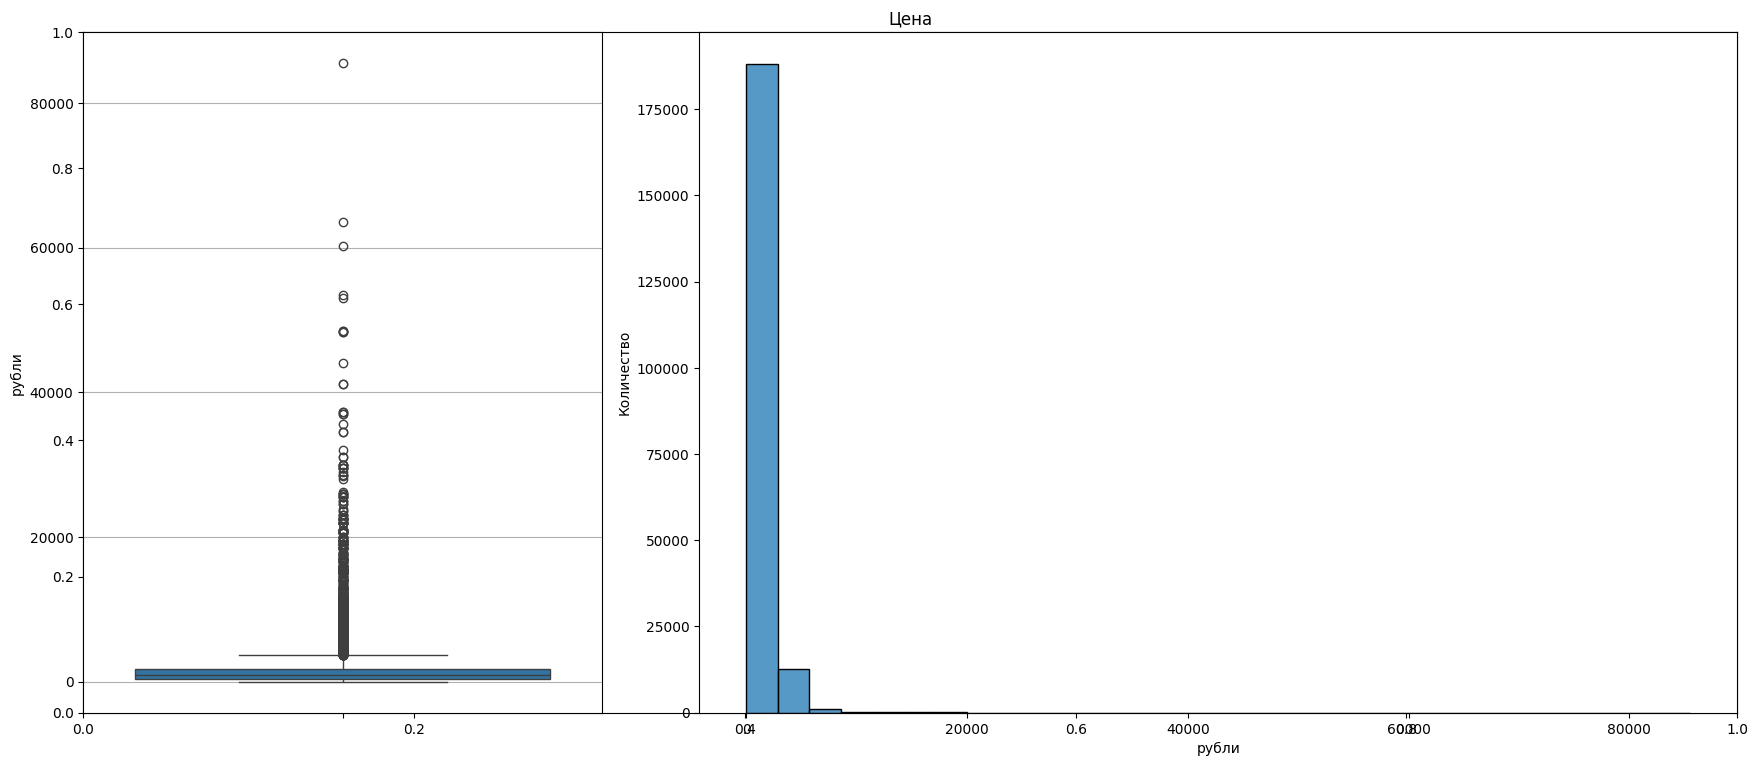

In [34]:
num_features_analysis(purchase_data, 'price', 'Цена', 'рубли')

Видно, что незначительное количество записей имеет крайне высокую цену товара.

Для моделирования это не очень удачно. т.к. по сути это выбросы в данных.

In [35]:
print(f"Покупок более 10 000 руб: {purchase_data[purchase_data['price'] > 10000].shape[0]} шт.\
({round(purchase_data[purchase_data['price'] > 10000].shape[0] / purchase_data.shape[0] * 100, 2)}%)")

Покупок более 10 000 руб: 332 шт.(0.16%)


 Записей с ценой более 10 000 руб всего 332 шт (две десятых процента). Исключим записи с ценой товара более 10 000 руб из дальнейшего анализа.

In [36]:
# Удалим все покупки с ценой более 10 000 руб
purchase_data = purchase_data[purchase_data['price'] < 10000]

,price
count,201876.000000
mean,1166.056641
std,1100.234375
min,1.000000
25%,350.000000
50%,980.000000
75%,1699.000000
max,9999.000000


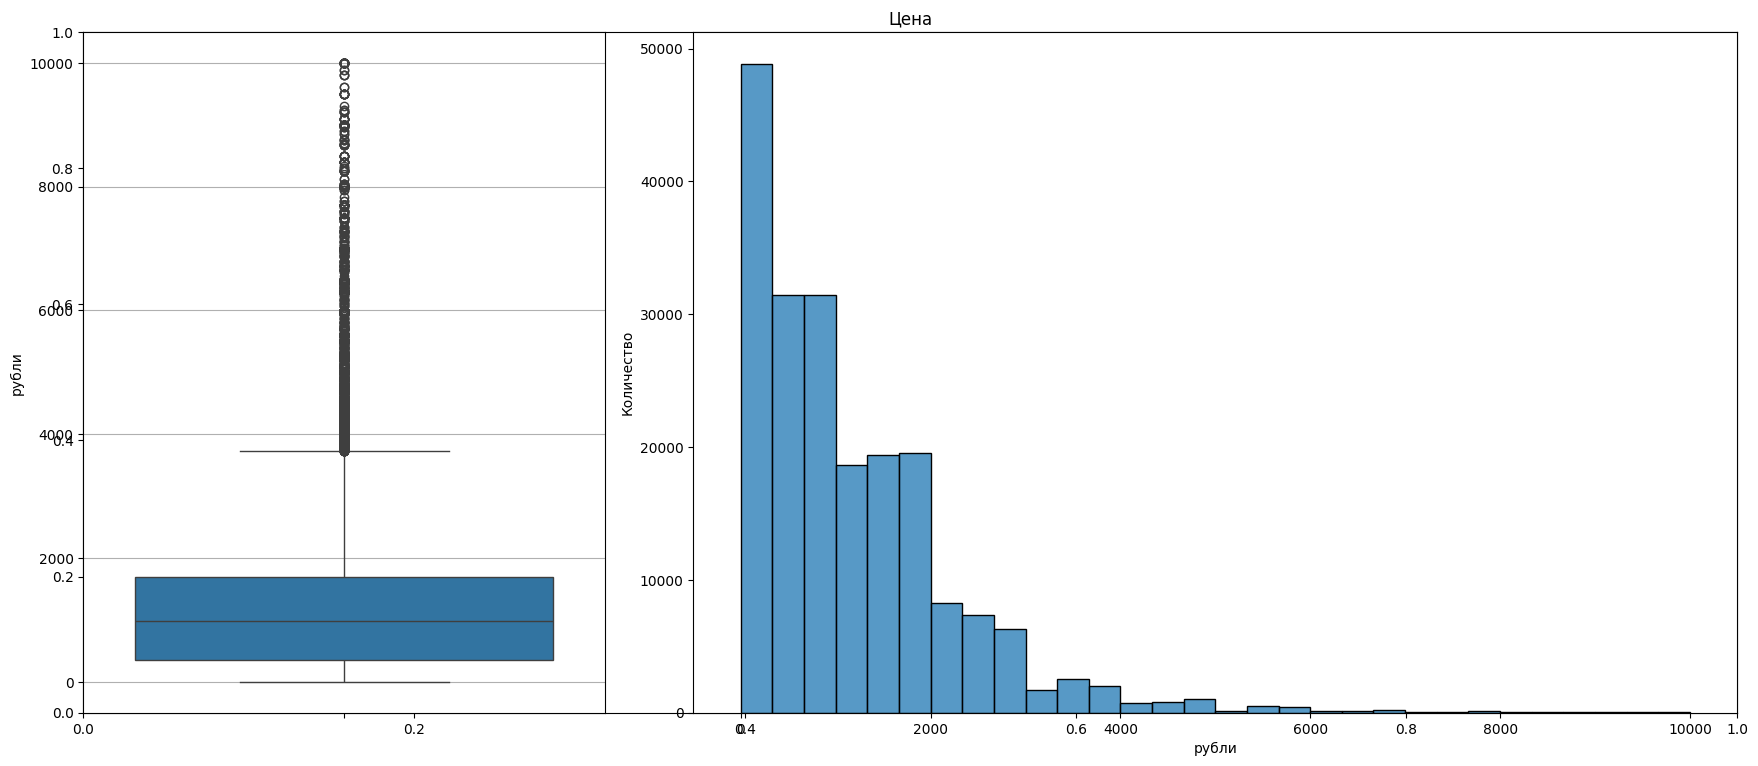

In [37]:
num_features_analysis(purchase_data, 'price', 'Цена', 'рубли')

Распределение стало существенно лучше.

Основные покупки сосредоточены в ценовой категории до 2000 рублей.

#### Категории товаров

При знакомстве с данными мы выяснили, что значений столбца category_ids очень много - 933. Работать с таким количеством при анализе будет затруднительно.

Поэтому разобьем столбец с категориями на два:
- в первом сохрагим самую верхнюю категорию
- во втором самую нижнюю

Все промежуточные пока не будем учитывать в анализе.

In [38]:
# Выделим верхнюю и нижнюю категорию из списка

def split_cat(row):
  # Удалим квадратные скобки
  tmp_str = row['category_ids'].replace('[', '').replace(']', '')
  # Делим строку на части
  cat_list = tmp_str.split(', ')

  lvl_top = 0
  lvl_low = 0

  if len(cat_list) == 5:
    lvl_top = int(cat_list[0].replace("'", ''))
    lvl_low = int(cat_list[4].replace("'", ''))
  elif len(cat_list) == 4:
    lvl_top = int(cat_list[0].replace("'", ''))
    lvl_low = int(cat_list[3].replace("'", ''))
  elif len(cat_list) == 3:
    lvl_top = int(cat_list[0].replace("'", ''))
    lvl_low = int(cat_list[2].replace("'", ''))
  elif len(cat_list) == 2:
    lvl_top = int(cat_list[0].replace("'", ''))
    lvl_low = int(cat_list[1].replace("'", ''))

  return lvl_top, lvl_low

(purchase_data['category_top'],
 purchase_data['category_low']) = zip(*purchase_data.apply(split_cat, axis=1))

In [39]:
purchase_data.head().T

,0,1,2,3,4
client_id,1515915625468169594,1515915625468169594,1515915625471138230,1515915625471138230,1515915625471138230
quantity,1,1,1,1,1
price,1999.0,2499.0,6499.0,4999.0,4999.0
category_ids,"['4', '28', '57', '431']","['4', '28', '57', '431']","['4', '28', '57', '431']","['4', '28', '244', '432']","['4', '28', '49', '413']"
date,2022-05-16 00:00:00,2022-05-16 00:00:00,2022-05-16 00:00:00,2022-05-16 00:00:00,2022-05-16 00:00:00
message_id,1515915625468169594-4301-627b661e9736d,1515915625468169594-4301-627b661e9736d,1515915625471138230-4437-6282242f27843,1515915625471138230-4437-6282242f27843,1515915625471138230-4437-6282242f27843
category_top,4,4,4,4,4
category_low,431,431,431,432,413


С такими категориями уже можно будет строить агрегации в дальнейшем

#### Даты покупок

In [50]:
purchase_data['date'].min()

Timestamp('2022-05-16 00:00:00')

In [51]:
purchase_data['date'].max()

Timestamp('2024-02-16 00:00:00')

Информация о покупках есть с середины мая 2022 года по середину февраля 2024 года.

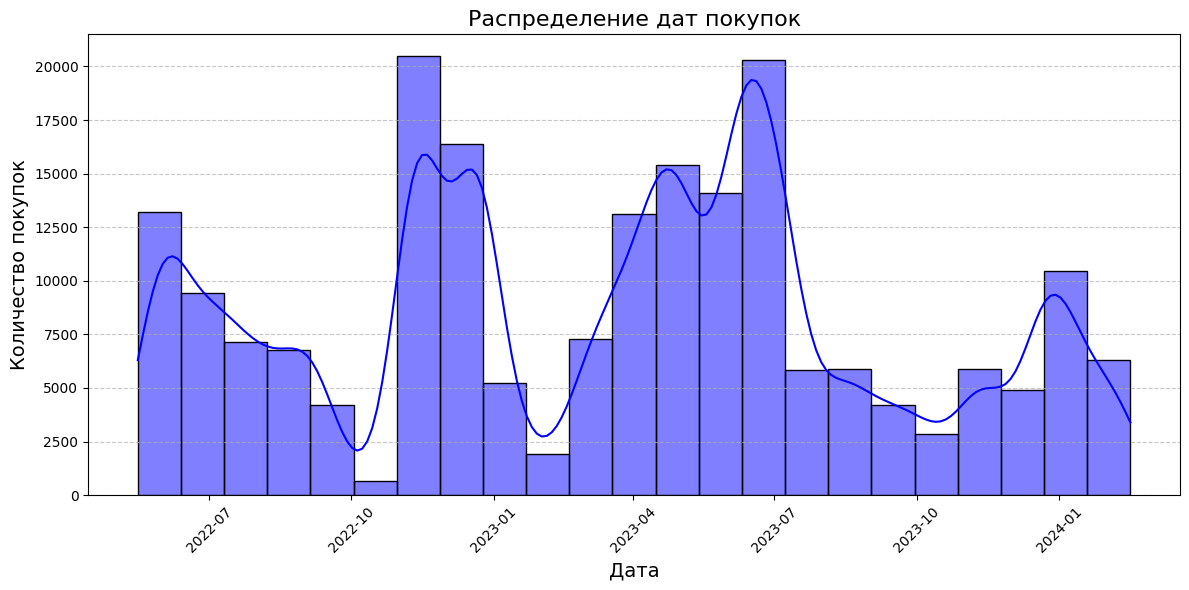

In [56]:
date_analysis(purchase_data, 'date',
              'Распределение дат покупок', 'Количество покупок', bins=23)

Активность пользователей по месяцам очень неравномерная. Строгих сезонных закономерностей не просматривается.

#### Проверка валидности данных на основе сообщений

При загрузке данных мы разобрали структуру идентификатора сообщения.

Попробуем проверить консистентность данных по совпадению идентификатора пользователя и его же, но уже как части сообщения.

In [40]:
# Разделим id сообщения на три составные части

def split_message_id(row):
  # Делим строку на части
  msg_list = row['message_id'].split('-')
  return int(msg_list[0]), int(msg_list[1]), msg_list[2]

(purchase_data['msg_client_id'],
 purchase_data['msg_compain_id'],
 purchase_data['msg_id']) = zip(*purchase_data.apply(split_message_id, axis=1))

In [41]:
purchase_data.head().T

,0,1,2,3,4
client_id,1515915625468169594,1515915625468169594,1515915625471138230,1515915625471138230,1515915625471138230
quantity,1,1,1,1,1
price,1999.0,2499.0,6499.0,4999.0,4999.0
category_ids,"['4', '28', '57', '431']","['4', '28', '57', '431']","['4', '28', '57', '431']","['4', '28', '244', '432']","['4', '28', '49', '413']"
date,2022-05-16 00:00:00,2022-05-16 00:00:00,2022-05-16 00:00:00,2022-05-16 00:00:00,2022-05-16 00:00:00
message_id,1515915625468169594-4301-627b661e9736d,1515915625468169594-4301-627b661e9736d,1515915625471138230-4437-6282242f27843,1515915625471138230-4437-6282242f27843,1515915625471138230-4437-6282242f27843
category_top,4,4,4,4,4
category_low,431,431,431,432,413
msg_client_id,1515915625468169594,1515915625468169594,1515915625471138230,1515915625471138230,1515915625471138230
msg_compain_id,4301,4301,4437,4437,4437


Теперь посмотрим совпадают ли идентификаторы пользователей.

In [42]:
purchase_data[purchase_data['client_id'] != purchase_data['msg_client_id']]

,client_id,quantity,price,category_ids,date,message_id,category_top,category_low,msg_client_id,msg_compain_id,msg_id
28,1515915625684011633,1,3599.0,"['2', '18', '258', '441']",2022-05-16,1515915625491871768-3948-62592654633be,2,441,1515915625491871768,3948,62592654633be
29,1515915625730423268,1,1199.0,"['4', '28', '57', '431']",2022-05-16,1515915625490751146-4301-627b6626b6d85,4,431,1515915625490751146,4301,627b6626b6d85
30,1515915625776110064,1,1299.0,"['4', '31', '326', '505']",2022-05-16,1515915625468120968-4273-6274ceb961997,4,505,1515915625468120968,4273,6274ceb961997
31,1515915625776110064,1,2199.0,"['4', '28', '260', '420']",2022-05-16,1515915625468120968-4273-6274ceb961997,4,420,1515915625468120968,4273,6274ceb961997
372,1515915625535950983,1,399.0,"['2', '18', '267', '1330']",2022-05-17,1515915625498833429-4301-627b66176547d,2,1330,1515915625498833429,4301,627b66176547d
...,...,...,...,...,...,...,...,...,...,...,...
202169,1515915626008613107,1,599.0,"['5562', '5536', '5714', '1588']",2024-02-16,1515915625551706109-14668-65cf5211c61ec,5562,1588,1515915625551706109,14668,65cf5211c61ec
202204,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,4,462,1515915625776605028,14662,65cf3abfe4f0d
202205,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,4,462,1515915625776605028,14662,65cf3abfe4f0d
202206,1515915626010443527,1,1999.0,"['2', '18', '274', '446']",2024-02-16,1515915625766077627-14668-65cf5246bd490,2,446,1515915625766077627,14668,65cf5246bd490


Для более чем 55 000 записей о покупках информация об id клиента в сообщении отличается от самого id клиента.

Это похоже на не очень качественно выгруженные данные, т.к. представить себе реальную ситуацию, что такое количество клиентов реагирует на чужие сообщения почти не возможно.

### Данные о сообщениях

#### Статусы сообщений

In [43]:
# Посмотрим на распределение статусов сообщений
msgs_data['event'].value_counts()

,count
event,
send,9028267
open,3050917
click,482827
purchase,62472
unsubscribe,2833
complain,527
subscribe,85
close,1


Наблюдается классическая воронка по количеству сообщений в Статусах.

Никаких противоречий не видно.

#### Каналы рассылок

,Количество,%
channel,,
mobile_push,7428836,58.83
email,5199093,41.17


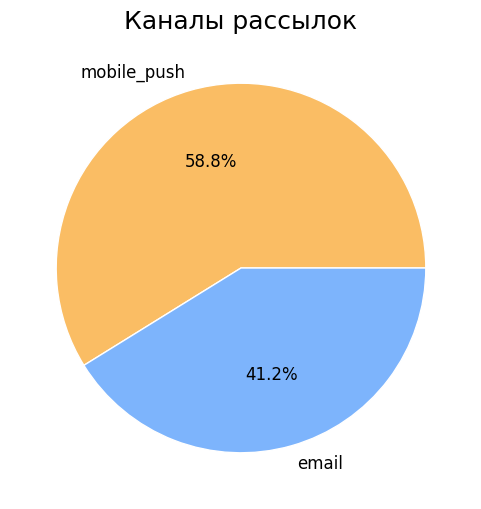

In [44]:
cat_features_analysis_df(msgs_data, 'channel', 'Каналы рассылок')

Почти 60% маркетинговой активности идет через push-уведомления и лишь 40% через Email.

#### Даты рассылки

In [57]:
msgs_data['date'].min()

Timestamp('2022-05-19 00:00:00')

In [58]:
msgs_data['date'].max()

Timestamp('2024-02-15 00:00:00')

Информация о рассылках есть с середины мая 2022 года по середину февраля 2024 года, т.е. она соответствует периоду с информацией о покупках.

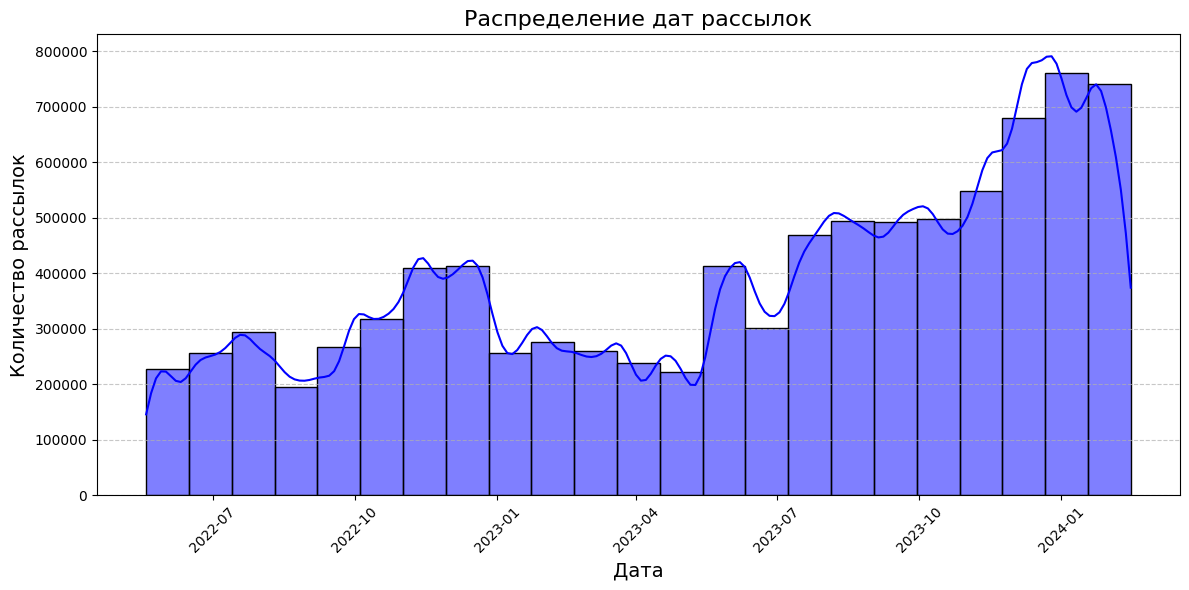

In [61]:
# построим гистограмму по датам отправки рассылок
date_analysis(msgs_data[msgs_data['event'] == 'send'], 'date',
              'Распределение дат рассылок', 'Количество рассылок', bins=23)

Активность по рассылкам по месяцам нарастает с середины 2023 года. Но она никак не отражается на количестве покупок (т.к. в этот период существенного роста покупок - нет).

### Выводы по анализу и предобработке данных

**Покупки:**
- Максимальное количество записей имеет всего 1 товар в графе количество. Это подтверждает наше предположение о том, что дублирующиеся записи - это, скорее всего, способ хранения информации.
- Мы исключили из анализа и моделирования записи с ценой товара более 10 000 руб (их было менее 0.2%).
- Основные покупки сосредоточены в ценовой категории до 2000 рублей.
- Из категорий товаров вычленили верхнюю и нижнюю категории.
- Информация о покупках есть с середины мая 2022 года по середину февраля 2024 года. Активность пользователей по месяцам очень неравномерная. Строгих сезонных закономерностей не просматривается.
- Для более чем 55 000 записей о покупках информация об id клиента в сообщении отличается от самого id клиента. *Это похоже на не очень качественно выгруженные данные, т.к. представить себе реальную ситуацию, что такое количество клиентов реагирует на чужие сообщения почти не возможно.*

**Рассылки:**
- Наблюдается классическая воронка по количеству сообщений в Статусах. Никаких противоречий не видно.
- Почти 60% маркетинговой активности идет через push-уведомления и лишь 40% через Email.
- Информация о рассылках есть с середины мая 2022 года по середину февраля 2024 года, т.е. она соответствует периоду с информацией о покупках.
- Активность по рассылкам по месяцам нарастает с середины 2023 года. Но она никак не отражается на количестве покупок (т.к. в этот период существенного роста покупок - нет).


## Создание новых признаков

В этом разделе соберем новые аггрегированные признаки для построения модели

### По таблице покупок



#### Время с последней покупки

Время в днях с момента последней покупки для каждого клиента.

Считаем время выгрузки по максимальной дате из таблицы покупок + 1 день.

*   Новый пункт
*   Новый пункт



In [64]:
# Получаем максимальную дату в выгрузке
upload_date = purchase_data['date'].max() + timedelta(days=1)

# Находим последнюю дату покупки для каждого клиента
last_purchase_dates = purchase_data.groupby('client_id')['date'].max().reset_index()
last_purchase_dates.rename(columns={'date': 'last_purchase_date'}, inplace=True)

# Рассчитываем разницу в днях
last_purchase_dates['last_purchase_date'] = (upload_date - last_purchase_dates['last_purchase_date']).dt.days
last_purchase_dates.sort_values('last_purchase_date', ascending=False)

,client_id,last_purchase_date
40132,1515915625730423268,642
41615,1515915625776110064,642
17836,1515915625493306434,642
19924,1515915625501479953,642
42169,1515915625783059271,642
...,...,...
35873,1515915625610269104,1
25517,1515915625557990155,1
8385,1515915625488518209,1
30344,1515915625574353628,1


#### Количество дней, когда были покупки

Посчитаем общее количество дней для каждого клиента, когда он совершал хотя бы одну покупку.

In [65]:
# Считаем количество уникальных дат покупок для каждого клиента
unique_days = purchase_data.groupby('client_id')['date'].nunique().reset_index()
unique_days.rename(columns={'date': 'unique_purchase_days'}, inplace=True)

unique_days.sort_values('unique_purchase_days', ascending=False)

,client_id,unique_purchase_days
44752,1515915625853312319,41
13475,1515915625490334876,23
45002,1515915625860624470,16
24615,1515915625554355124,16
18454,1515915625500232103,15
...,...,...
18106,1515915625496470604,1
18107,1515915625496500886,1
18108,1515915625496512609,1
18109,1515915625496559206,1


In [87]:
# Количество клиентов с более чем одной покупкой
unique_days[unique_days['unique_purchase_days'] > 1].count()

,0
client_id,7127
unique_purchase_days,7127


Большинство клиентов только один раз (один день) пользуется покупками на сайте.

#### Количество уникальных покупок

Посчитаем общее количество уникальных покупок для каждого клиента.

Уникальность определим по дате и разному идентификатору рассылки.

In [66]:
# Формируем уникальный идентификатор покупки
purchase_data['purchase_id'] = purchase_data.apply(lambda row: (row['date'], row['message_id']), axis=1)

# Считаем количество уникальных покупок для каждого клиента
unique_purchases = purchase_data.groupby('client_id')['purchase_id'].nunique().reset_index()
unique_purchases.rename(columns={'purchase_id': 'unique_purchases'}, inplace=True)

unique_purchases.sort_values('unique_purchases', ascending=False)

,client_id,unique_purchases
44752,1515915625853312319,41
13475,1515915625490334876,23
24615,1515915625554355124,17
45002,1515915625860624470,16
31561,1515915625579040539,15
...,...,...
18112,1515915625496612388,1
18113,1515915625496615792,1
18115,1515915625496641216,1
18116,1515915625496649488,1


#### Среднее количество товаров и средняя стоимость покупки

Рассчитаем сколько в среднем товаров было в одной покупке клиента и какова средняя стоимость этих покупок.

In [67]:
# Рассчитываем сумму покупки для каждой записи
purchase_data['purchase_total'] = purchase_data['quantity'] * purchase_data['price']

# Считаем общее количество товаров и общую стоимость для каждой покупки
purchases = purchase_data.groupby(['client_id', 'purchase_id']).agg(
    total_quantity=('quantity', 'sum'),
    total_price=('purchase_total', 'sum')
).reset_index()

# Считаем среднее количество товаров и среднюю стоимость для каждого клиента
client_stats = purchases.groupby('client_id').agg(
    avg_quantity_per_purchase=('total_quantity', 'mean'),
    avg_price_per_purchase=('total_price', 'mean')
).reset_index()

client_stats

,client_id,avg_quantity_per_purchase,avg_price_per_purchase
0,1515915625468060902,7.000000,6993.000000
1,1515915625468061003,7.000000,16235.000000
2,1515915625468061099,1.000000,299.000000
3,1515915625468061100,2.000000,2098.000000
4,1515915625468061170,6.333333,11200.333008
...,...,...,...
49747,1515915626010261344,6.000000,8994.000000
49748,1515915626010266132,2.000000,1818.000000
49749,1515915626010439406,2.000000,198.000000
49750,1515915626010443527,1.000000,1999.000000


#### Общая сумма покупок

Рассчитаем общую сумму денег, которую клиент потратил на сайте за все время.

In [68]:
# Рассчитываем общую сумму всех покупок для каждого клиента
total_spent = purchase_data.groupby('client_id')['purchase_total'].sum().reset_index()
total_spent.rename(columns={'purchase_total': 'total_spent'}, inplace=True)

total_spent.sort_values('total_spent', ascending=False)

,client_id,total_spent
44752,1515915625853312319,270987.0
18454,1515915625500232103,195013.0
48534,1515915625983356708,142128.0
31930,1515915625580548703,138558.0
25167,1515915625557342756,126303.0
...,...,...
26205,1515915625558835949,1.0
34700,1515915625590643562,1.0
23856,1515915625550303061,1.0
7941,1515915625488345285,1.0


In [70]:
# Количество клиентов с потраченной суммой более 20000
total_spent[total_spent['total_spent'] > 10000].count()

,0
client_id,5115
total_spent,5115


Всего около 5 000 клиентов за все время потратили на сайте более 10 000 рублей

####  Популярные категории

Выделим медианное значение по верхней и нижней категории в покупках каждого клиента.

In [71]:
# Для каждого клиента находим наиболее часто встречающуюся категорию верхнего уровня
most_frequent_category_top = purchase_data.groupby('client_id')['category_top']\
                                          .agg(lambda x: x.mode()[0]).reset_index()

most_frequent_category_top

,client_id,category_top
0,1515915625468060902,4
1,1515915625468061003,4
2,1515915625468061099,4
3,1515915625468061100,4
4,1515915625468061170,4
...,...,...
49747,1515915626010261344,2
49748,1515915626010266132,4
49749,1515915626010439406,4
49750,1515915626010443527,2


In [73]:
most_frequent_category_top['category_top'].mode()

,category_top
0,4


Наиболее популярны товары из верхней категории - 4

In [72]:
# Для каждого клиента находим наиболее часто встречающуюся категорию нижнего уровня
most_frequent_category_low = purchase_data.groupby('client_id')['category_low']\
                                          .agg(lambda x: x.mode()[0]).reset_index()

most_frequent_category_low

,client_id,category_low
0,1515915625468060902,420
1,1515915625468061003,615
2,1515915625468061099,424
3,1515915625468061100,5717
4,1515915625468061170,420
...,...,...
49747,1515915626010261344,726
49748,1515915626010266132,470
49749,1515915626010439406,462
49750,1515915626010443527,446


In [74]:
most_frequent_category_low['category_low'].mode()

,category_low
0,431


Наиболее популярны товары из нижней категории - 431

#### Максимальный и минимальный интервал между покупками

Для тех клиентов, которые совершили более одной покупки рассчитаем два параметра:
- минимальное количество дней между покупками
- максимальное количество дней между покупками

In [75]:
# Сортируем данные по client_id и date
df = purchase_data.sort_values(by=['client_id', 'date'])

# Вычисляем разницу в днях между последовательными покупками
purchase_data['days_diff'] = purchase_data.groupby('client_id')['date'].diff().dt.days

# Убираем строки с 0 разницей (т.е. те, что относятся к одному и тому же дню)
df = purchase_data[purchase_data['days_diff'] > 0]

# Для клиентов с более чем одной покупкой, вычисляем минимальный и максимальный срок между покупками
purchase_diff = df.groupby('client_id')['days_diff'].agg(['min', 'max']).reset_index()
purchase_diff.rename(columns={'min': 'min_purchace_interval', 'max':'max_purchace_interval'}, inplace=True)

purchase_diff

,client_id,min_purchace_interval,max_purchace_interval
0,1515915625468061170,3.0,80.0
1,1515915625468061994,29.0,29.0
2,1515915625468062158,340.0,340.0
3,1515915625468062659,54.0,54.0
4,1515915625468063026,189.0,393.0
...,...,...,...
7122,1515915626007958988,1.0,1.0
7123,1515915626007963061,1.0,1.0
7124,1515915626008514147,9.0,9.0
7125,1515915626009118362,2.0,9.0


Количество записей совпало с количеством покупателей, сделавших более 1 покупки, значит расчет верен.

### По таблице сообщений

#### Количество сообщений

Рассчитаем количество уникальных сообщений, которые получил каждый клиент

In [76]:
# Количество уникальных сообщений, с которыми взаимодействовал клиент
sent_messages = msgs_data.groupby('client_id')['message_id'].nunique()
sent_messages

,message_id
client_id,
1515915625468060902,127
1515915625468061003,154
1515915625468061099,213
1515915625468061100,266
1515915625468061170,243
...,...
1515915626010183608,2
1515915626010221592,2
1515915626010234726,1


#### Количество дней с отправками сообщений

Рассчитаем количество дней в которые клиенту отправлялись сообщения

In [77]:
# Количество дней, в которые клиенту отправлялись сообщения
days_with_messages = msgs_data[msgs_data['event'] == 'send'].groupby('client_id')['date'].nunique()
days_with_messages

,date
client_id,
1515915625468060902,125
1515915625468061003,153
1515915625468061099,188
1515915625468061100,224
1515915625468061170,199
...,...
1515915626010183608,1
1515915626010221592,1
1515915626010234726,1


#### Срок в днях с последней отправки сообщения

Посчитаем сколько дней прошло с момента отправки последнего сообщения клиенту.

In [78]:
# Получаем максимальную дату в выгрузке + 1
upload_date_msg = msgs_data['date'].max() + timedelta(days=1)
# Срок в днях с момента последнего отправленного сообщения до выгрузки данных
last_sent_date = msgs_data[msgs_data['event'] == 'send'].groupby('client_id')['date'].max()
days_since_last_message = (upload_date_msg - last_sent_date).dt.days
days_since_last_message

,date
client_id,
1515915625468060902,28
1515915625468061003,3
1515915625468061099,3
1515915625468061100,1
1515915625468061170,1
...,...
1515915626010183608,1
1515915626010221592,1
1515915626010234726,1


#### Процент положительных реакций (лояльность)

Рассчитаем на какой процент сообщений клиент отреагировал хотя бы одной положительной реакцией.

In [79]:
# Процент положительных реакций
positive_events = ['open', 'click', 'purchase', 'subscribe']
# Удаляем дублирующиеся положительные реакции на одно и то же сообщение
unique_positive_responses = msgs_data[msgs_data['event']\
                                      .isin(positive_events)]\
                                      .drop_duplicates(subset=['client_id',
                                                               'message_id'])

# Общее количество отправленных сообщений
total_sent = msgs_data[msgs_data['event'] == 'send']\
                      .groupby('client_id')['message_id']\
                      .count()

# Количество сообщений с положительной реакцией
positive_responses = unique_positive_responses.groupby('client_id')['message_id'].count()

# Расчёт процента положительных реакций
positive_response_rate = (positive_responses / total_sent).fillna(0) * 100
positive_response_rate

,message_id
client_id,
1515915625468060902,26.190476
1515915625468061003,3.246753
1515915625468061099,23.004695
1515915625468061100,57.518797
1515915625468061170,12.757202
...,...
1515915626010183608,100.000000
1515915626010221592,100.000000
1515915626010234726,0.000000


Сведем все признаки по рассылкам в единую таблицу

In [81]:
result_msg = pd.DataFrame({
    'unique_messages': sent_messages,
    'days_with_sent_messages': days_with_messages,
    'days_since_last_sent_message': days_since_last_message,
    'positive_response_rate': positive_response_rate
}).reset_index()
result_msg

,client_id,unique_messages,days_with_sent_messages,days_since_last_sent_message,positive_response_rate
0,1515915625468060902,127,125.0,28.0,26.190476
1,1515915625468061003,154,153.0,3.0,3.246753
2,1515915625468061099,213,188.0,3.0,23.004695
3,1515915625468061100,266,224.0,1.0,57.518797
4,1515915625468061170,243,199.0,1.0,12.757202
...,...,...,...,...,...
53245,1515915626010183608,2,1.0,1.0,100.000000
53246,1515915626010221592,2,1.0,1.0,100.000000
53247,1515915626010234726,1,1.0,1.0,0.000000
53248,1515915626010261344,1,1.0,1.0,100.000000


### Объединение новых признаков

Сведем все новые признаки в общую таблицу для использования ее при дальнейшем анализе корреляции и моделировании.

In [82]:
# Объединяем все метрики в одну таблицу
result = pd.merge(last_purchase_dates, unique_days, on='client_id', how='left')
result = pd.merge(result, unique_purchases, on='client_id', how='left')
result = pd.merge(result, client_stats, on='client_id', how='left')
result = pd.merge(result, total_spent, on='client_id', how='left')
result = pd.merge(result, purchase_diff, on='client_id', how='left')
result = pd.merge(result, most_frequent_category_top, on='client_id', how='left')
result = pd.merge(result, most_frequent_category_low, on='client_id', how='left')
result = pd.merge(result, result_msg, on='client_id', how='left')

result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49752 entries, 0 to 49751
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   client_id                     49752 non-null  int64  
 1   last_purchase_date            49752 non-null  int64  
 2   unique_purchase_days          49752 non-null  int64  
 3   unique_purchases              49752 non-null  int64  
 4   avg_quantity_per_purchase     49752 non-null  float64
 5   avg_price_per_purchase        49752 non-null  float32
 6   total_spent                   49752 non-null  float32
 7   min_purchace_interval         7127 non-null   float64
 8   max_purchace_interval         7127 non-null   float64
 9   category_top                  49752 non-null  int64  
 10  category_low                  49752 non-null  int64  
 11  unique_messages               41854 non-null  float64
 12  days_with_sent_messages       41853 non-null  float64
 13  d

Часть данных осталась не заполненной. Заполним эти пропуски 0.

In [83]:
result = result.fillna(0)
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49752 entries, 0 to 49751
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   client_id                     49752 non-null  int64  
 1   last_purchase_date            49752 non-null  int64  
 2   unique_purchase_days          49752 non-null  int64  
 3   unique_purchases              49752 non-null  int64  
 4   avg_quantity_per_purchase     49752 non-null  float64
 5   avg_price_per_purchase        49752 non-null  float32
 6   total_spent                   49752 non-null  float32
 7   min_purchace_interval         49752 non-null  float64
 8   max_purchace_interval         49752 non-null  float64
 9   category_top                  49752 non-null  int64  
 10  category_low                  49752 non-null  int64  
 11  unique_messages               49752 non-null  float64
 12  days_with_sent_messages       49752 non-null  float64
 13  d

In [84]:
result = optimize_memory_usage(result)

Размер использования памяти: до  5.31 Mb - после  2.47 Mb (53.6%)


Добавим значение Таргета

In [85]:
# Добавим Таргет
result = pd.merge(result, target_data, on='client_id', how='left')

In [86]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49752 entries, 0 to 49751
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   client_id                     49752 non-null  int64  
 1   last_purchase_date            49752 non-null  int16  
 2   unique_purchase_days          49752 non-null  int8   
 3   unique_purchases              49752 non-null  int8   
 4   avg_quantity_per_purchase     49752 non-null  float32
 5   avg_price_per_purchase        49752 non-null  float32
 6   total_spent                   49752 non-null  float32
 7   min_purchace_interval         49752 non-null  float32
 8   max_purchace_interval         49752 non-null  float32
 9   category_top                  49752 non-null  int16  
 10  category_low                  49752 non-null  int16  
 11  unique_messages               49752 non-null  float32
 12  days_with_sent_messages       49752 non-null  float32
 13  d

### Итоги

Нам удалось создать 14 аггрегированных признаков по каждому клиенту Интернет-магазина.
- Время с последней покупки
- Количество дней, когда были покупки
- Количество уникальных покупок
- Среднее количество товаров в покупке
- Средняя стоимость покупки
- Общая сумма покупок
- Популярные категории (верхняя и нижняя)
- Максимальный и минимальный интервал между покупками
- Количество сообщений
- Количество дней с отправками сообщений
- Срок в днях с последней отправки сообщения
- Процент положительных реакций (лояльность)

Их мы и будем использовать в дальнейшем корреляционном анализе и моделировании

## Корреляционный анализ

Проведем корреляционный анализ признаков, которые мы считаем могут быть полезны при построении модели.

In [87]:
num_col = ['last_purchase_date',
           'unique_purchase_days',
           'unique_purchases',
           'avg_quantity_per_purchase',
           'avg_price_per_purchase',
           'total_spent',
           'min_purchace_interval',
           'max_purchace_interval',
           'category_top',
           'category_low',
           'unique_messages',
           'days_with_sent_messages',
           'days_since_last_sent_message',
           'positive_response_rate']
target_col = ['target']

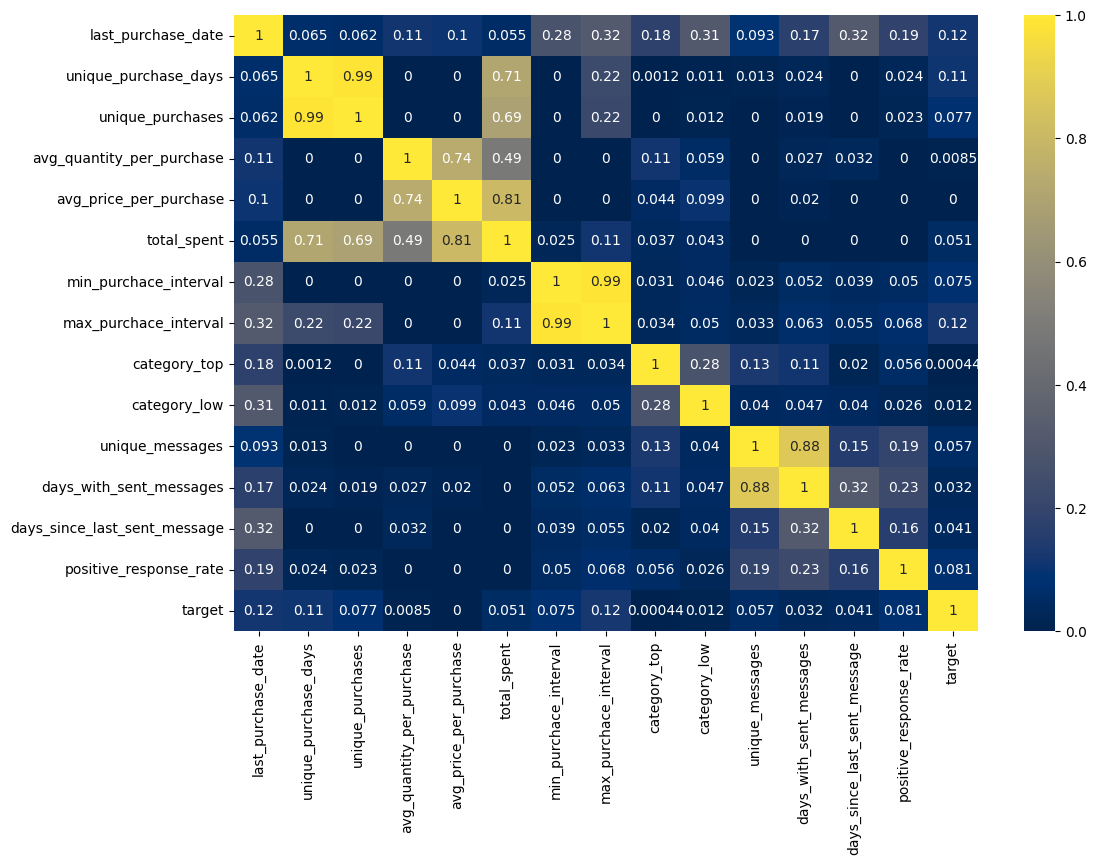

In [88]:
# Построим матрицу корреляции
plt.figure(figsize=(12, 8))
sns.heatmap(result[num_col+target_col].phik_matrix(interval_cols=num_col+target_col),
            annot=True,
            cmap='cividis');

Корреляцию с Таргетом показывают следующие признаки:
- `last_purchase_date` - 12%
- `max_purchace_interval` - 12%
- `unique_purchase_days` - 11%
- `positive_response_rate` - 8.1%
- `unique_purchases` - 7.7%
- `min_purchace_interval` - 7.5%
- `unique_messages` - 5.7%
- `total_spent` - 5.1%
- `days_since_last_sent_message` - 4.1%
- `days_with_sent_messages` - 3.2%
- `category_low` - 1.2%

При этом пары категорий:
- `unique_purchases` и `unique_purchase_days`
- `min_purchace_interval` и `max_purchace_interval`
- `unique_messages` и `days_with_sent_messages`

мультиколинеарны между собой и в модели стоит использовать только какую-то одну из пары. Выберем ту, где выше корреляция.

## Моделирование

### Выбор признаков и моделирование на Тренировочном сете


Опираясь на данные корреляционного анализа составим набор признаков необходимых для моделирования

In [89]:
num_col = ['last_purchase_date',
           'max_purchace_interval',
           'unique_purchase_days',
           'positive_response_rate',
           'unique_messages',
           'total_spent',
           'days_since_last_sent_message',
           'category_low']
target_col = ['target']

In [90]:
# Разделим выборку на тренировочную, валидационную и тестовую
X_train, X_test, y_train, y_test = split_data(result, [], num_col)

In [91]:
# Создадим пайплайн для масштабирования числовых признаков
# Пропусков в данных нет, поэтому не применяем заполнение
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(),
         num_col
        )
    ],
    remainder='passthrough'
)

# итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', CatBoostClassifier(iterations=100,
                                      learning_rate=0.1,
                                      depth=6,
                                      random_state=RANDOM_STATE,
                                      verbose=0))
    ]
)

In [92]:
# Зададим начальные значения параметров
param_grid = {
    'models': [
        DecisionTreeClassifier(max_depth=12,
                               min_samples_leaf=4,
                               min_samples_split=3,
                               random_state=RANDOM_STATE),
        LGBMClassifier(n_estimators=100,
                       learning_rate=0.1,
                       max_depth=3,
                       metric='roc-auc',
                       verbose=-1,
                       random_state=RANDOM_STATE),
        CatBoostClassifier(iterations=100,
                           learning_rate=0.1,
                           depth=3,
                           random_state=RANDOM_STATE,
                           verbose=0)
        ]
     }

In [93]:
warnings.filterwarnings('ignore')
grid = param_search(X_train, y_train, scoring='roc_auc')

Метрика "roc_auc" для лучшей модели:  0.72952 

Лучшая модель:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['last_purchase_date',
                                                   'max_purchace_interval',
                                                   'unique_purchase_days',
                                                   'positive_response_rate',
                                                   'unique_messages',
                                                   'total_spent',
                                                   'days_since_last_sent_message',
                                                   'category_low'])])),
                ('models',
                 LGBMClassifier(max_depth=3, metric='roc-auc', random_state=42,
                                verbose=-1))])
Параметры модели:

 {

In [94]:
# Подберем гиперпараметры для модели
param_grid = {
    'models': [LGBMClassifier(metric='roc-auc',
                              verbose=-1,
                              random_state=RANDOM_STATE)],
    'models__n_estimators': [120, 130],
    'models__learning_rate': [0.1, 0.05],
    'models__max_depth': [1, 2, 3]
     }

In [95]:
warnings.filterwarnings('ignore')
grid = param_search(X_train, y_train, scoring='roc_auc')

Метрика "roc_auc" для лучшей модели:  0.73487 

Лучшая модель:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['last_purchase_date',
                                                   'max_purchace_interval',
                                                   'unique_purchase_days',
                                                   'positive_response_rate',
                                                   'unique_messages',
                                                   'total_spent',
                                                   'days_since_last_sent_message',
                                                   'category_low'])])),
                ('models',
                 LGBMClassifier(learning_rate=0.05, max_depth=2,
                                metric='roc-auc', n_estimators=130,
               

### Проверка на тестовой выборке

In [96]:
#Проверка модели на валидационных данных
model_predict(grid.best_estimator_)

Метрика ROC_AUC на тестовой выборке: 0.756
Метрика F1 на тестовой выборке: 0.0


Требуемый порого в 0.7 для метрики ROC-ФГС на тестовой выборке достигнут.

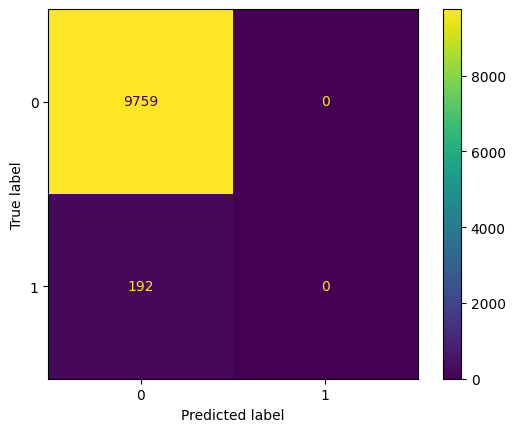

In [97]:
conf_matrix(grid.best_estimator_);

Увы, модель отлично предсказывает 0 значения и 100% ошибается при предсказании 1 значений.

Если для целей бизнеса важно будет определеять пользователей, которые совершат повторную покупку, то нужно будет настраивать порог определения 0 и 1, чтобы снизить количество ошибок второго рода.

### Проверка важности признаков

In [98]:
# Получим модель по нашим лучшим параметрам
best_model = grid.best_estimator_.named_steps['models']

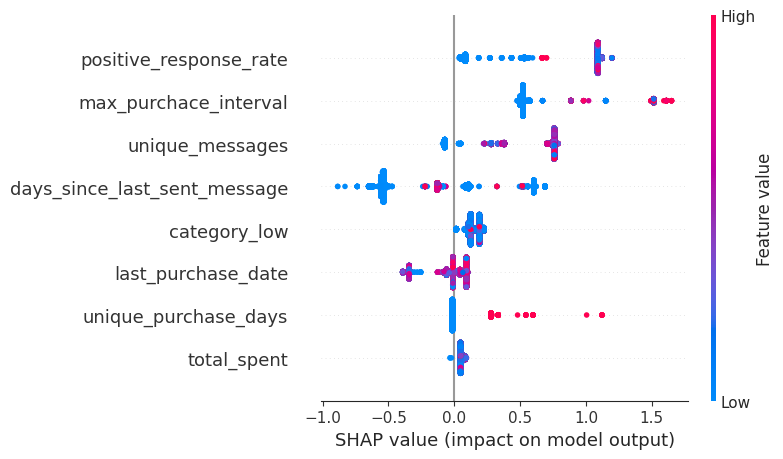

In [104]:
# Создание объекта explainer для SHAP
explainer = shap.TreeExplainer(best_model)

# Вычисление SHAP значений для тестового набора
shap_values = explainer.shap_values(X_test)

# Построение графика значимости признаков
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

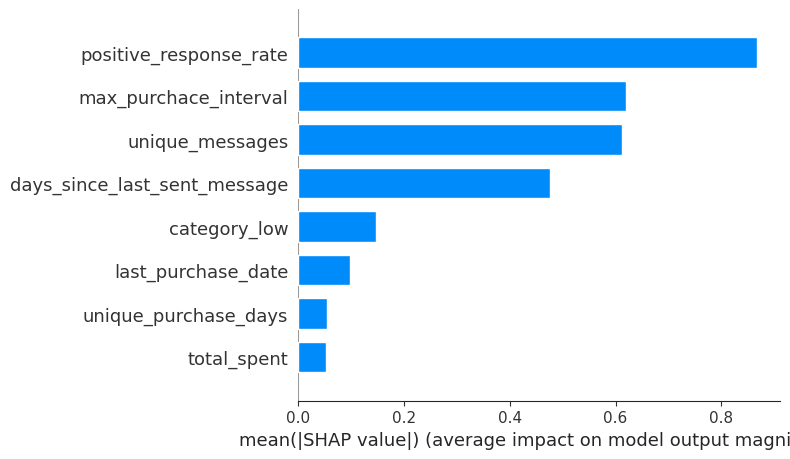

In [110]:
# Построение графика - глобальная значимость признаков для прогноза модели.
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar")

Наиболее значимыми получились признаки:
- Процент положительных реакций (лояльность)
- Максимальный интервал между покупками
- Количество сообщений
- Срок в днях с последней отправки сообщения

## Выводы

**Знакомство с данными**
- В нашем распоряжении данные о покупках почти 50 000 клиентов
- Очень много дублирующихся записей в информации о покупках (почти 70 000), но мы не стали их удалять, т.к.
  - в дате покупки нет времени и это могут быть валидные покупки от одного пользователя в течении одного дня
  - таким образом может хранить данные магазин, просто записывая каждую единицу товара отдельной строкой в БД
- Таргет распределен очень неравномерно. Вероятность повторной покупки на сайте не превышает 2%.
- 93% клиентов, получающих рассылки хоть раз совершали покупки на сайте.
- Из информации о рассылках мы удалили события, закончившиеся недоставкой к клиенту и также удалили около 50 000 дублирующихся полностью записей
- Пропусков в данных всех таблиц нет
- Именования столбцов согласно стандарту

**Анализ и предобработка данных**
- Мы исключили из анализа и моделирования записи с ценой товара более 10 000 руб (их было менее 0.2%).
- Основные покупки сосредоточены в ценовой категории до 2000 рублей.
- Из категорий товаров вычленили верхнюю и нижнюю категории.
- Информация о покупках есть с середины мая 2022 года по середину февраля 2024 года. Активность пользователей по месяцам очень неравномерная. Строгих сезонных закономерностей не просматривается.
- Для более чем 55 000 записей о покупках информация об id клиента в сообщении отличается от самого id клиента. *Это похоже на не очень качественно выгруженные данные, т.к. представить себе реальную ситуацию, что такое количество клиентов реагирует на чужие сообщения почти не возможно.*
- Наблюдается классическая воронка по количеству сообщений в Статусах рассылок. Никаких противоречий не видно.
- Почти 60% маркетинговой активности идет через push-уведомления и лишь 40% через Email.
- Информация о рассылках есть с середины мая 2022 года по середину февраля 2024 года, т.е. она соответствует периоду с информацией о покупках.
- Активность по рассылкам по месяцам нарастает с середины 2023 года. Но она никак не отражается на количестве покупок (т.к. в этот период существенного роста покупок - нет).

**Создание признаков**

Нам удалось создать 14 аггрегированных признаков по каждому клиенту Интернет-магазина.
- Время с последней покупки
- Количество дней, когда были покупки
- Количество уникальных покупок
- Среднее количество товаров в покупке
- Средняя стоимость покупки
- Общая сумма покупок
- Популярные категории (верхняя и нижняя)
- Максимальный и минимальный интервал между покупками
- Количество сообщений
- Количество дней с отправками сообщений
- Срок в днях с последней отправки сообщения
- Процент положительных реакций (лояльность)

После корреляционного анализа для дальнейшего построения модели мы оставили 8:
- Время с последней покупки
- Максимальный и минимальный интервал между покупками     
- Количество дней, когда были покупки
- Процент положительных реакций (лояльность)
- Количество сообщений
- Общая сумма покупок
- Срок в днях с последней отправки сообщения         
- Популярная категория нижнего уровня

**Моделирование**

Лучший результат с метрикой Roc-Auc = 0.756 на тестовой выборке показала модель:
- LGBMClassifier
  - learning_rate = 0.05
  - max_depth = 2
  - n_estimators = 130

К сожалению, эта модель отлично предсказывает 0 значения и 100% ошибается при предсказании 1 значений.

Если для целей бизнеса важно будет определеять пользователей, которые совершат повторную покупку, то нужно будет настраивать порог определения 0 и 1, чтобы снизить количество ошибок второго рода.

Наиболее значимыми получились для результата получились признаки:
- Процент положительных реакций (лояльность)
- Максимальный интервал между покупками
- Количество сообщений
- Срок в днях с последней отправки сообщения

Судя по всему огромная маркетинговая активнсть играет отрицательную роль в том, чтобы пользователи совершали повторные покупки. На это стоит обратить внимание.